In [1]:
import numpy as np

import os
from os.path import join
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.trainer as trainer
import torch.utils.data as data_utils

from scripts.utils import mkdir
from scripts.bbox_data_preproc import load_dataset

In [2]:
batch_size = 32
LR = 0.001
n_epoch = 1000


dataset_name = 'data001_size192'
train_name = 'detector_002'
data_dir = '/workdir/data/detect_data/{0}'.format(dataset_name)
model_save_dir = '/workdir/data/models/{0}/{1}/'.format(dataset_name, train_name)
mkdir(model_save_dir)

# Load data

In [3]:
img_size = (224, 224)

X_train, y_train, X_val, y_val = load_dataset(data_dir, img_size, 15000)

Load data


In [4]:
train = data_utils.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

val = data_utils.TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

# Model

In [5]:
from scripts.models import Detector

def get_model():
    model = Detector()
    
    optimizer = torch.optim.Adam(model.parameters(), LR)
    model = torch.nn.DataParallel(model).cuda()
    # model = model.cuda()
    
    criterion = nn.L1Loss().cuda()
    
    return model, criterion, optimizer

In [6]:
model, criterion, optimizer = get_model()

# Train

In [9]:
def train(model, train_loader):
    model.train()
    train_loss = 0
    train_count = 0
    for i, (input, target) in enumerate(train_loader):
        target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)
        
        optimizer.zero_grad()
        output = model(input_var)
        loss = criterion(output, target_var)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
        train_count += 1
    return train_loss / train_count

def validate(model, val_loader):
    model.eval()
    val_loss = 0
    val_count = 0
    for i, (input, target) in enumerate(val_loader):
        
        target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)
        
        output = model(input_var)
        loss = criterion(output, target_var)
        val_loss += loss.data[0]
        val_count += 1
    return val_loss / val_count

In [10]:
for epoch in range(0, n_epoch):
    train_loss = train(model, train_loader)
    val_loss = validate(model, val_loader)
    print("Epoch {0}: train {1} \t val {2}".format(epoch, train_loss, val_loss))

Epoch 0: train 17.053188624920875 	 val 13.231120122445596
Epoch 1: train 13.91152842263423 	 val 12.903140235591579
Epoch 2: train 13.414280067883066 	 val 12.31360117164818
Epoch 3: train 13.02453057954052 	 val 12.816465699994886
Epoch 4: train 12.797467422892035 	 val 11.929914165187526
Epoch 5: train 12.32286236687764 	 val 11.604760234420365
Epoch 6: train 12.161445806783908 	 val 11.728974097483867
Epoch 7: train 11.87443016027845 	 val 11.334061274657378
Epoch 8: train 11.57122896068386 	 val 11.51347659085248
Epoch 9: train 11.405853763572189 	 val 10.550211932208088
Epoch 10: train 11.232540472229914 	 val 11.491866910779798
Epoch 11: train 10.983012770793078 	 val 10.162859613830978
Epoch 12: train 10.772776530495584 	 val 10.252024019086683
Epoch 13: train 10.648172998733358 	 val 9.847372274141055
Epoch 14: train 10.522158163188617 	 val 10.691604356507998
Epoch 15: train 10.349154244607954 	 val 10.641946844152502
Epoch 16: train 10.194293857891676 	 val 10.72883462905883

KeyboardInterrupt: 

In [11]:
val_loss = validate(model, val_loader)
val_loss

9.7203369849437

# Save model

In [10]:
state = {
    'epoch': epoch + 1,
    'arch': train_name,
    'state_dict': model.state_dict(),
    'val_loss': val_loss,
    'img_size': img_size
}
torch.save(state, join(model_save_dir, 'model.pth.tar'))

# Load model

In [11]:
state = torch.load(join(model_save_dir, 'model.pth.tar'))
print(state['arch'], state['val_loss'], state['epoch'])

detector_002 9.7203369849437 203


In [12]:
model.load_state_dict(state['state_dict'])

In [13]:
from scripts.bbox_data_preproc import netout2points, check_poly
from scripts.utils import show_bgr

import matplotlib.pyplot as plt
%matplotlib inline

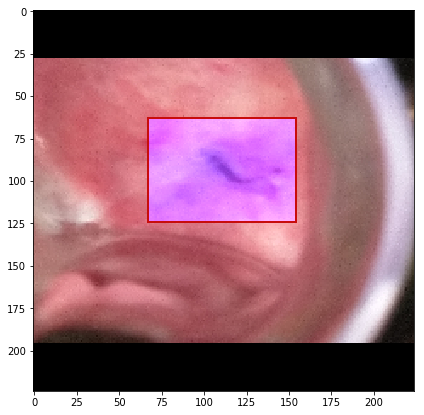

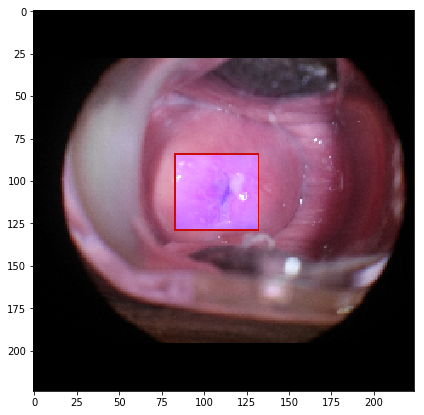

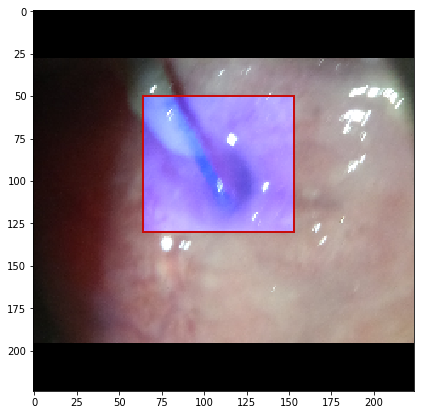

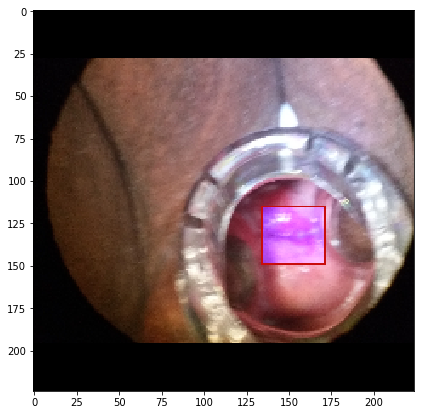

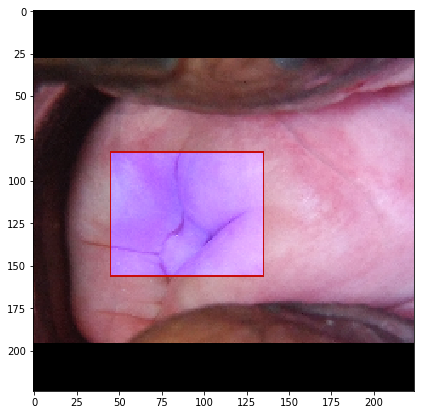

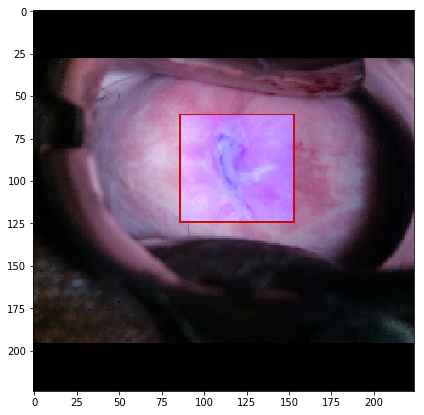

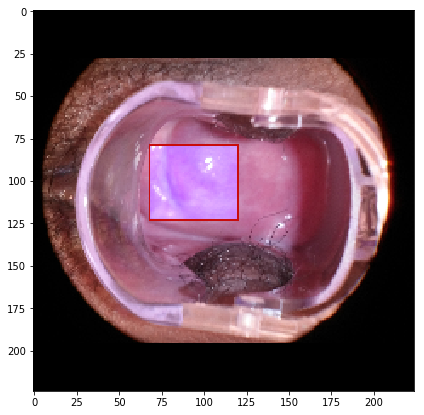

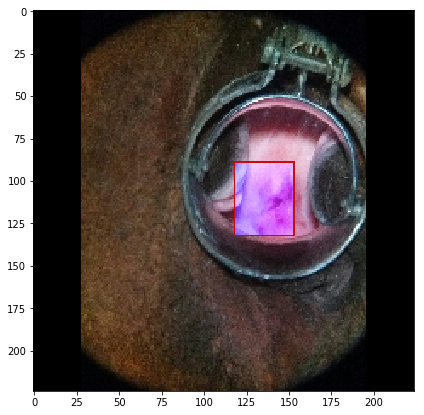

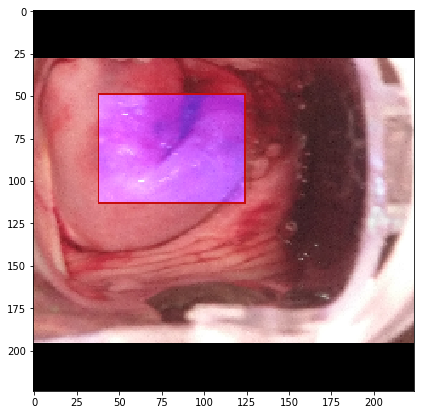

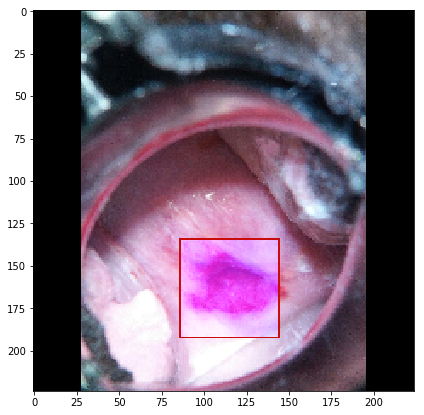

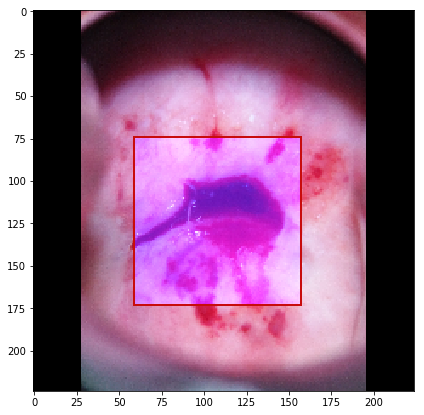

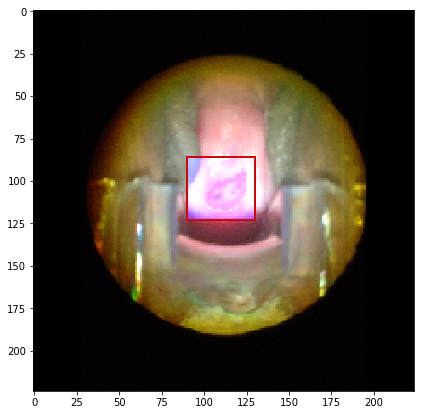

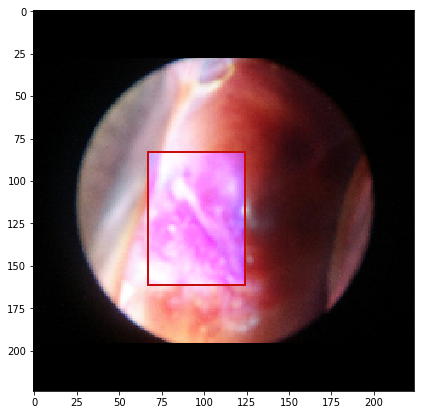

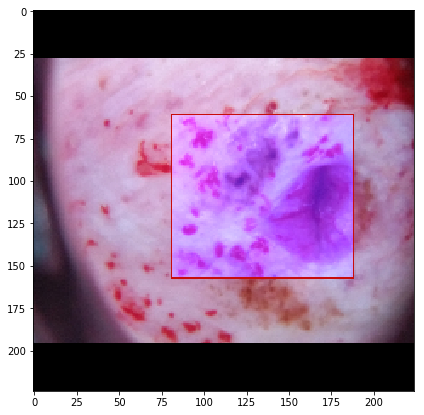

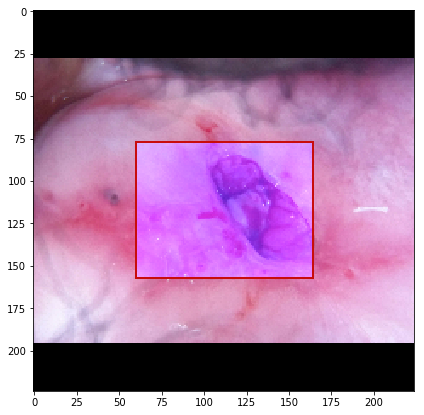

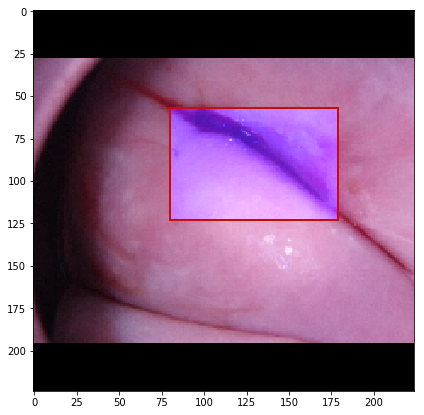

In [14]:
model.eval()
for i, (input, target) in enumerate(val_loader):

    target = target.cuda(async=True)
    input_var = torch.autograd.Variable(input, volatile=True)
    target_var = torch.autograd.Variable(target, volatile=True)
    output = model(input_var)
    break

for img_num in range(16):
    netout = output.data.cpu().numpy()[img_num]
    points = netout2points(netout)
    img = input_var.data.cpu().numpy()[img_num]
    img = img.transpose((1, 2, 0)).astype(np.uint8)
    show_bgr(check_poly(img, points))